## Advection Equation with Boundary Conditions using Finite Differences and the Method of Lines


**Authors:** Joaquín Pelle, Oscar Reula, Pablo Montes
##### [Click here to download this notebook](/weave/lab04/SAT.ipynb)

We will solve the advection equation using the *method of lines* and *finite differences*. Since there will be non-periodic boundary conditions, we will use ***penalty methods*** to impose the field values at the boundaries.

We will solve the advection equation

$$
u_t = -c u_x
$$

We assume that $c>0$, so that the wave propagates to the right with speed $c$. We will solve this equation in the spatial interval $[0, L]$. Note that, since the solution travels to the right, we only need to specify boundary values on the left side, that is, at the point $x=0$.

For example, below we show the exact solution of the advection equation for the initial condition $u(x,0) = 0$ and boundary condition $u(0,t) = \sin(t)$ in the spatial interval $[0, 2\pi]$.

┌ Info: Saved animation to /home/pablo/Documentos/SAFIR/pde_private/Tareas/Tarea_3/Advection_Example.gif
└ @ Plots /home/pablo/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/home/pablo/Documentos/SAFIR/pde_private/Tareas/Tarea_3/Advection_Example.gif")
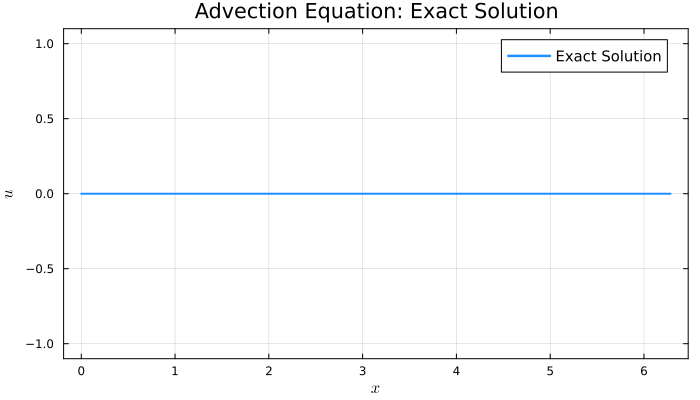

In [56]:
using Plots

# Number of spatial points
N = 1001

# Spatial domain length
L = 2.0 * π

# Spatial step size
dx = L / (N - 1)

# Spatial grid points
x = [dx * (i - 1) for i in 1:N]

# Time values
times = range(0, 20, length = 400)

# Advection speed (can be any value greater than 0)
c = 1.0

# Initial condition (feel free to change this function)
function u_0(x)
    return 0
end

# Boundary condition at x = 0 (feel free to change this as well)
# Ideally, ensure g(t=0) == u_0(x=0)
function g(t)
    return sin(t)
end

# Exact solution to the advection equation
function solution(x, t)
    if x > c * t
        return u_0(c * t - x)
    else
        return g(t - x / c)
    end
end

anim = @animate for t in times
    p = plot(
        x, solution.(x, t),
        ylim = (-1.1, 1.1),
        xlabel = "\$x\$",
        ylabel = "\$u\$",
        legend = :topright,
        label = "Exact Solution",
        linewidth = 2,
        linecolor = :dodgerblue,
        framestyle = :box,
        legendfontsize = 10,
        title = "Advection Equation: Exact Solution"
    )
    plot(p, size=(700, 400))
end

gif(anim, "Advection_Example.gif", fps = 30)

We will represent the interval $[0,2\pi]$ with a grid of $N$ points, $P_N = \{(i-1)\Delta x : i = 1,\ldots,N \,, \; \Delta x= 2\pi/(N-1)  \}$. Then, if $I \subset \mathbb{R}$ is a time interval, the spatial discretization of the solution $u \colon [0,2\pi] \times I \to \mathbb{R}$ will take the form $v \colon P_N \times I \to \mathbb{R}$, or equivalently $v \colon I \to \mathbb{R}^N$ (that is, a grid vector at each instant). 

Additionally, we will approximate the spatial derivative using a finite difference operator $D_x \colon \mathbb{R}^N \to \mathbb{R}^N$, obtaining the following system of ODEs:

\begin{equation}
v_t = -c D_x v.
\end{equation}

Note that, unlike in the previous exercise, the operator $D_x$ will not be periodic. Finally, we will proceed to approximate the ODE system using a suitable integrator. In this way, we obtain a system that is discretized in both time and space.

Now we define the finite difference schemes. These are implemented as matrices that multiply the solution vectors. The matrices are defined as sparse for greater computational efficiency.

We will start with the second-order method, as it is simpler. Instead of the operator we used for the periodic case, we will use finite difference operators that satisfy ***Summation By Parts***, known as **SBP** operators.

These operators satisfy properties analogous to those of derivatives when integrated. In particular, the following property holds:

$$
\int_a^b \left [u(x) \frac{dv(x)}{dx} + \frac{du(x)}{dx} v(x) \right]\; dx = v(b)u(b) - v(a)u(a)
$$

At the discrete level, this corresponds to:

$$
\sum_{ij} h^{ij}[u_i (Dv)_j + (Du)_i v_j] = u[N]v[N] - u[1]v[1]\,,
$$

where the form $h$ defines an inner product, which will be our discrete version of the inner product $\langle u,v \rangle = \int uv dx$. For second- and fourth-order approximations, there exists a unique pair $(h, D)$ with $h$ diagonal, such that this property holds. However, for higher-order schemes, there are more degrees of freedom. $h$ can be a diagonal bilinear form or something more complicated. This may become important for problems in several dimensions, but for now we will restrict ourselves to diagonal forms of $h$.

### Wait a moment, why do we want this property?

Suppose we have the advection equation on the interval $[a, b]$. We can define an energy for the solution as

$$
E(t) = \dfrac{1}{2}\int_{a}^{b} u(t,x)^{2}dx.
$$

This energy satisfies $E(t) > 0$ for all $t$ and

\begin{align}
\dfrac{dE}{dt} &= \dfrac{d}{dt} \dfrac{1}{2}\int_{a}^{b} u(t,x)^{2}dx\\
&= \int \dfrac{\partial u(t,x)}{\partial t} u dx\\
&= -\int c\dfrac{\partial u(t,x)}{\partial x} u dx\\
&= -\int \frac{c}{2}\dfrac{\partial u(t,x)^2}{\partial x}\, dx\\
&= \dfrac{c}{2} \left( u(a,t)^{2} - u(b,t)^{2} \right )
\end{align}

where we have used the advection equation to go from a time derivative to a spatial derivative. In the periodic case, $u(a,t) = u(b,t)$, so $\dfrac{dE}{dt} = 0$. Put differently, the rate of change of energy depends only on what happens at the domain boundaries: that is, on *how much energy flows out and how much enters* at the boundaries.

When we discretize space, we want to ensure that this type of relationship is preserved, or at the very least, that in problems where energy should remain constant, it does not grow unexpectedly.
Let's try to repeat these steps for the semi-discrete equation. Now,

$$
E(t) = \dfrac{1}{2}\sum_{ij} h_{ij} u_{i}(t) u_{j}(t) \Delta x
$$

and the time derivative becomes

\begin{align}
\dfrac{dE}{dt} &= \dfrac{d}{dt} \dfrac{1}{2}\sum_{ij} h_{ij} u_{i}(t) u_{j}(t) \Delta x \\
&= \dfrac{1}{2}\sum_{ij} h_{ij} \left( \dfrac{du_{i}}{dt}(t) u_{j}(t) + \dfrac{du_{j}}{dt}(t) u_{i}(t) \right) \Delta x \\
&= -c \dfrac{1}{2}\sum_{ij} h_{ij} \left( (Du)_{i}(t) u_{j}(t) + (Du)_{j}(t) u_{i}(t) \right) \Delta x
\end{align}

and, in principle, we cannot proceed further. However, the summation by parts property lets us take one step further, and allows us to obtain

$$
\dfrac{dE}{dt} = \frac{c}{2} \left(u_1^{2} - u_N^{2} \right ).
$$

### Second-Order SBP Operator

We are using Julia, so we will load some packages to handle matrices, solve ODEs, and create plots.

In [57]:
using DifferentialEquations
using Plots
using LinearAlgebra
using BandedMatrices
using SparseArrays

In [58]:
function create_D_2_sbp(N)
    # Construct the tridiagonal SBP derivative operator
    D = Tridiagonal(
        [-0.5 for _ in 1:N-1],  # subdiagonal: -0.5
        [ 0.0 for _ in 1:N   ], # diagonal: 0.0
        [ 0.5 for _ in 1:N-1]   # superdiagonal: 0.5
    )
    # Modify entries at the boundaries for first-order accuracy
    D[1,1]   = -1.0
    D[1,2]   =  1.0
    D[end,end]   =  1.0
    D[end,end-1] = -1.0

    # Create the diagonal inner product matrix H
    H_diag = ones(N)
    H_diag[1]   = 0.5
    H_diag[end] = 0.5
    H = Diagonal(H_diag)

    return H, D
end

create_D_2_sbp (generic function with 1 method)

In [59]:
h2, D_2_sbp = create_D_2_sbp(8)
println("Inner product matrix H:")
display(h2)
println("Second-order derivative operator in the interior, first-order at the boundary:")
display(D_2_sbp)

8×8 Diagonal{Float64, Vector{Float64}}:
 0.5   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   0.5

8×8 Tridiagonal{Float64, Vector{Float64}}:
 -1.0   1.0    ⋅     ⋅     ⋅     ⋅     ⋅    ⋅ 
 -0.5   0.0   0.5    ⋅     ⋅     ⋅     ⋅    ⋅ 
   ⋅   -0.5   0.0   0.5    ⋅     ⋅     ⋅    ⋅ 
   ⋅     ⋅   -0.5   0.0   0.5    ⋅     ⋅    ⋅ 
   ⋅     ⋅     ⋅   -0.5   0.0   0.5    ⋅    ⋅ 
   ⋅     ⋅     ⋅     ⋅   -0.5   0.0   0.5   ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅   -0.5   0.0  0.5
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -1.0  1.0

Inner product matrix H:
Second-order derivative operator in the interior, first-order at the boundary:


We can check that the summation by parts condition is satisfied. Recall that we want

$$
\sum_{ij} h^{ij}[u_i (Dv)_j + (Du)_i v_j] = u[N]v[N] - u[1]v[1],
$$

or, equivalently,

$$
(hDv)^{T}u + (hDu)^{T}v = u[N]v[N] - u[1]v[1]
$$

for all $u$ and for all $v$.

In [60]:
N = 400
h2, D_2_sbp = create_D_2_sbp(N)
u = rand(N)  # Define a completely random u
v = rand(N)  # Define a completely random v

# h(Dv)'u 
println("The following number should be 0 (or a ridiculously small number, close to 10^-16):")
println((h2 * (D_2_sbp * v))' * u + (h2 * (D_2_sbp * u))' * v - (u[N]*v[N] - u[1]*v[1]))

The following number should be 0 (or a ridiculously small number, close to 10^-16):
0.0


### Boundary Condition

We will add the boundary condition at $x=0$ by including a penalty term on the right-hand side of the advection equation. This type of term is called **SAT**, which stands for ***Simultaneous Approximation Terms***.

$$
(u_t)_i = c (D_x\, u)_i + \delta_{i1} \textrm{SAT}_1 + \delta_{iN} \textrm{SAT}_N.
$$

In this case, $\textrm{SAT}_N = 0$ since we do not need to impose a boundary condition on the right. Meanwhile, $\textrm{SAT}_1$ is defined as

$$
\textrm{SAT}_1 = \frac{c}{h_{11}\Delta x}(g(t) - u_1)
$$

where $g(t)$ is the boundary condition we wish to impose. Note that this equation introduces a source term at the first grid point, which forces it to exponentially decay toward the solution $g(t)$.

### Energy Conservation

Let us repeat the calculation to see how the energy of the system behaves:

$$
\begin{align}
\dfrac{dE}{dt} &= \dfrac{d}{dt} \dfrac{1}{2}\sum_{ij}h_{ij}u_{i}(t)u_{j}(t) \Delta x \\
&= \dfrac{1}{2}\sum_{ij}h_{ij}\left(\dfrac{du_{i}}{dt}(t)u_{j}(t) + \dfrac{du_{j}}{dt}(t)u_{i}(t)\right) \Delta x \\
&= -c \dfrac{1}{2}\sum_{ij}h_{ij} \left((Du)_{i}(t)u_{j}(t) + (Du)_{j}(t)u_{i}(t)\right) \Delta x \\
&\quad+ \dfrac{c}{h_{11}\Delta x}\dfrac{1}{2}\sum_{ij}h_{ij} \left( \delta_{i1} (g(t)-u_1)u_j + \delta_{j1} (g(t)-u_1)u_i \right )\Delta x\\
&= \frac{c}{2} \left( u_1(t)^{2}-u_N(t)^{2} \right) + c\left( g(t)u_1(t) - u_1(t)^{2}\right)\\
&= \frac{c}{2} (2g(t)u_1(t) + u_1(t)^2 - u_N(t)^2)
\end{align}
$$


We want this to be less than or equal to $\frac{c}{2}(g(t)^2-u_N(t)^2)$
In order to achieve this, we can add and substract $\frac{g(t)^2}{2}$. This will turn the equation into

$$
\begin{align}
&= \frac{c}{2} \left( g(t)^{2}-u_N(t)^{2} \right) + \frac{c}{2}\left(- g(t)^2 + 2g(t)u_1(t) - u_1(t)^{2}\right)\\
&= \frac{c}{2} \left( g(t)^{2}-u_N(t)^{2} \right) - \frac{c}{2}\left(g(t)-u_1(t)\right)^{2}\\
&\le \frac{c}{2} (g(t)^2-u_N(t)^2),
\end{align}
$$


where we have used the fact that $h_{ij}$ is diagonal. This result is consistent with the original equation and can be used to demonstrate the stability of the solution.
We can also see that the original equation satisfies the conservation law

$$
\dfrac{d}{dt} \int_{a}^{b} u(x,t)\,dx = -c\,(u(b,t)-u(a,t)),
$$

and the semi-discrete formulation with SAT terms satisfies

$$
\dfrac{d}{dt}\sum_{ij}h_{ij}u_{i}\mathbf{1}_{j}\Delta x = -c\,(g(t)-u_N(t)),
$$

where $\mathbf{1}$ is a vector of length $N$ with all elements equal to one, so we see that conservation is preserved.

Now let's present an example. We define two functions that will evolve the advection equation using the second-order SBP operator. One does so using a matrix, and the other performs the computation directly. Both functions are equivalent.

In [61]:
function F_sbp_matrix!(du,u,p,t)
    # second order version
    h11, D, c,g, parg,dx = p
    h = 1. /dx
    mul!(du, D, u, -c*h,0)
    du[1] += c * (h/h11)*(g(t, parg) - u[1])
end


F_sbp_matrix! (generic function with 1 method)

In [62]:
function F2_sbp!(du, u, p, t)
    # Second-order version of SBP derivative
    c, g, parg, dx = p
    # c    -> propagation speed (must be > 0)
    # g    -> boundary condition function
    # parg -> parameters for the boundary condition function
    h = 1.0 / dx
    h11 = 0.5  # (1,1) component of the inner product matrix

    # First, update the interior points
    # du[i] = c * (u[i+1] - u[i-1]) / dx
    @. du[2:end-1] = -c * 0.5 * h * (u[3:end] - u[1:end-2])

    # Now update the boundary points
    du[end] = -c * h * (u[end] - u[end-1])           # First-order derivative at the right boundary (SBP-satisfying)
    du[1] = ( -c * h * (u[2] - u[1])                 # First-order derivative at the left boundary (SBP-satisfying)
              + c * h / h11 * (g(t, parg) - u[1]) )  # SAT term (Simultaneous Approximation Term)
end

F2_sbp! (generic function with 1 method)

Now we add some parameters for the simulation. Some values are arbitrary, and you can try experimenting with them. $N$ is the number of points in the spatial discretization.

**Initial Data**

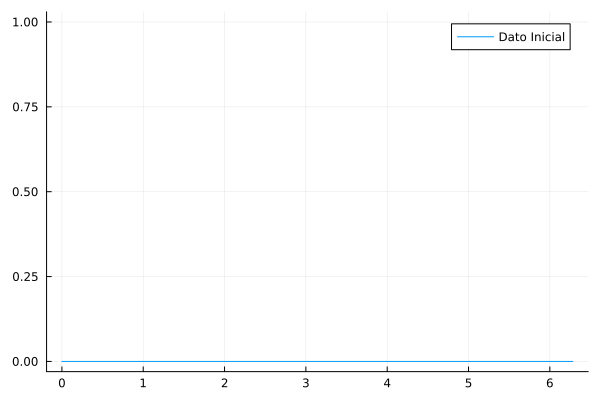

In [63]:
#Initial data
N = 400                                #Número de puntos
dx = 2*pi/(N-1)                           #Δx
x = [dx*(i-1) for i in 1:N]            #Discretización Espacial
u0 = zeros(N)                          #Vector del dato inicial
x0=1.0
x1 = 2.5
p=8
for i in 1:N
    if x[i] > x0 && x[i] < x1
        u0[i] = 0.0*(x[i] - x0)^p * (x[i] - x1)^p / (0.5*(x1-x0))^(2p)
    end
end

plot(x,u0, label = "Dato Inicial")

**Evolution parameters**

In [64]:
c = 1.0              # Advection speed

# Boundary condition at x=0. You can change this to anything you like!
function g(t, ω)
    return 0.5*(sin(t * ω))
end

T = 10.0             # Final evolution time
ω = 3.0
p = (c, g, ω, dx)

# Create the second-order SBP operator
h2, D_2_sbp = create_D_2_sbp(N)

# Tuple of parameters for the matrix approach
pmatrix = (h2[1,1], D_2_sbp, c, g, ω, dx)

dt = dx / c          # dt ≈ dx / MaxVelocity for stability

0.01574733159694132

Now we are going to solve the problem in two different ways.

In [65]:
# Define the problems for the two approaches
matrix_prob = ODEProblem(F_sbp_matrix!, u0, (0.0, T), pmatrix)
direct_prob = ODEProblem(F2_sbp!, u0, (0.0, T), p);

And now we solve

In [66]:
@time solmatrix = solve(matrix_prob,RK4(),dt=dt, adaptive = false);

  0.011968 seconds (24.04 k allocations: 6.787 MiB, 86.27% compilation time: 100% of which was recompilation)


In [67]:
@time sol = solve(direct_prob,RK4(),dt=dt, adaptive = false);

  0.097445 seconds (267.71 k allocations: 34.496 MiB, 16.65% gc time, 78.85% compilation time: 100% of which was recompilation)


Finally, we plot both solutions:

┌ Info: Saved animation to /home/pablo/Documentos/SAFIR/pde_private/Tareas/Tarea_3/wave_anim.gif
└ @ Plots /home/pablo/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/home/pablo/Documentos/SAFIR/pde_private/Tareas/Tarea_3/wave_anim.gif")
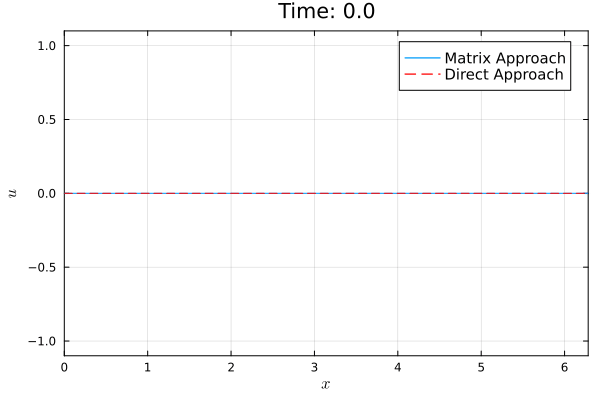

In [68]:
anim = @animate for t in solmatrix.t
    plot(x, solmatrix(t), label = "Matrix Approach")
    plot!(x, sol(t), label = "Direct Approach", legend = :topright, linestyle = :dash, linecolor = :red)
    title!("Time: $(round(t, digits=2))")
    xlabel!("\$x\$")
    ylabel!("\$u\$")
    plot!(ylim = (-1.1, 1.1), xlim = (0, 2π), legendfontsize = 10, framestyle = :box)
    #plot(sol2(T*0.005*i)[:,1])
end

gif(anim, "wave_anim.gif", fps = 30)
    

Now it would be nice to do some energy estimates:

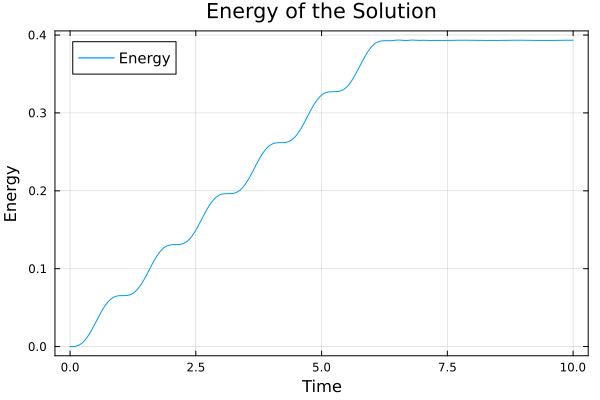

In [69]:
function Energy(u, h2, dx)
    # Compute the energy of the solution
    return 0.5 * (u' * h2 * u) * dx
end
energy = copy(sol.t)

for (i,t) in enumerate(sol.t)
    energy[i] = Energy(sol(t), h2, dx)
end
plot(sol.t, energy, label = "Energy", xlabel = "Time", ylabel = "Energy", title = "Energy of the Solution", legendfontsize = 10, framestyle = :box)
